In [1]:
%pip install wfdb numpy scipy matplotlib scikit-learn pandas==2.1.4


  Using cached wfdb-4.3.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached tzdata-2025.3-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached fsspec-2026.1.0-py3-none-any.whl.metadata (10 kB)
INFO: pip is looking at multiple versions of wfdb to determine which version is compatible with other requirements. This could take a while.
  Using cached soundfile-0.13.1-py2.py3-none-win_amd64.whl.metadata (16 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.3.2-py3-none-any.whl.metadata (5.8 kB)
  Using cached joblib-1.5.3-py3-none-any.whl.metadata (5.5 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached idna-3.11-py3-none-any.whl.metadata (8.4 kB)
  Using cached urllib3-2.6.3-py3-none-any.whl.metadata (6.9 kB)
  Using cached certifi-2026.1.4-py3-none-any.whl.metadata (2.5 kB)
  Using cached pycparser-3.0-py3-none-any.whl.metadata (8.2 kB)
   ---

In [2]:
import wfdb
import numpy as np

record_path = "dataset/100"   # correct path

# Read ECG signal
record = wfdb.rdrecord(record_path)
signal = record.p_signal[:, 0]   # use channel 1 (MLII)

# Read annotations
annotation = wfdb.rdann(record_path, 'atr')

print("Signal shape:", signal.shape)
print("Sampling rate:", record.fs)
print("Number of beats:", len(annotation.sample))


Signal shape: (650000,)
Sampling rate: 360
Number of beats: 2274


Band Pass Filtering

In [3]:
from scipy.signal import butter, filtfilt

def bandpass_filter(ecg, lowcut=0.5, highcut=40, fs=360, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, ecg)

filtered_ecg = bandpass_filter(signal)


Normalization

In [4]:
def normalize(ecg):
    return (ecg - np.mean(ecg)) / np.std(ecg)

normalized_ecg = normalize(filtered_ecg)


Beat Segmentation (using R peaks)

In [5]:
pre_r = int(0.2 * record.fs)
post_r = int(0.4 * record.fs)

beats = []
labels = []

for r_peak, label in zip(annotation.sample, annotation.symbol):
    start = r_peak - pre_r
    end = r_peak + post_r

    if start >= 0 and end < len(normalized_ecg):
        beat = normalized_ecg[start:end]
        beats.append(beat)
        labels.append(label)

beats = np.array(beats)
labels = np.array(labels)

print("Beats shape:", beats.shape)


Beats shape: (2272, 216)


Label Mapping (NSR / AFIB / AFL)

In [6]:
def map_label(symbol):
    if symbol == 'N':
        return 0  # NSR
    elif symbol in ['A', 'a']:
        return 1  # AFIB
    elif symbol == 'F':
        return 2  # AFL
    else:
        return -1  # ignore

mapped_labels = np.array([map_label(l) for l in labels])

# Remove ignored beats
valid = mapped_labels != -1
X = beats[valid]
y = mapped_labels[valid]

print("Final dataset:", X.shape, y.shape)


Final dataset: (2271, 216) (2271,)


(Reshape for CNN / CNN-LSTM)

In [7]:
X = X.reshape(X.shape[0], X.shape[1], 1)

print("CNN input shape:", X.shape)


CNN input shape: (2271, 216, 1)


Visualization

Signal-Level Verification (Raw vs Filtered)
✔ Baseline wander reduced
✔ High-frequency noise reduced
✔ QRS complexes still sharp

Matplotlib is building the font cache; this may take a moment.


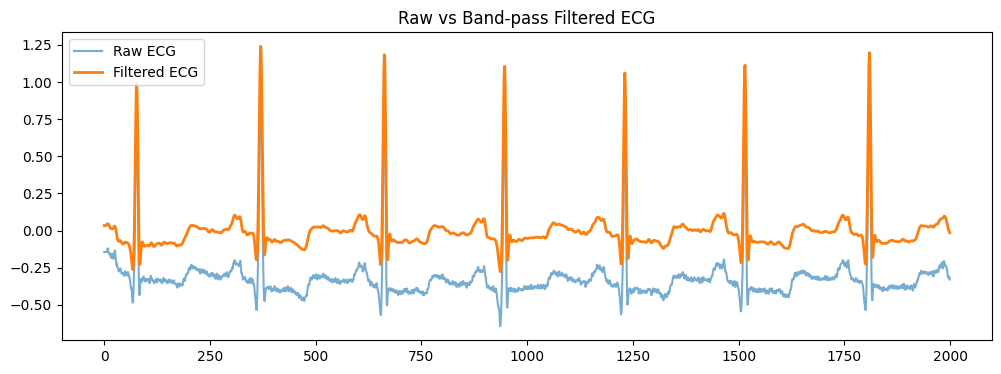

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(signal[:2000], label="Raw ECG", alpha=0.6)
plt.plot(filtered_ecg[:2000], label="Filtered ECG", linewidth=2)
plt.legend()
plt.title("Raw vs Band-pass Filtered ECG")
plt.show()


Beat-Level Verification (Segmentation Correctness)
✔ R-peak near center
✔ Smooth P–QRS–T shape

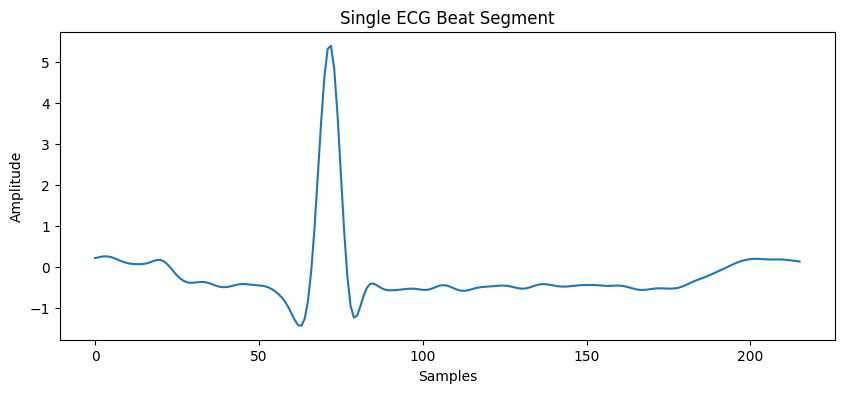

In [9]:
plt.figure(figsize=(10,4))
plt.plot(X[0].flatten())
plt.title("Single ECG Beat Segment")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()


Label-Level Verification (Correct Class Mapping)
✔ Labels are integers
✔ No -1 present
✔ Class imbalance is expected in ECG

In [10]:
import numpy as np

unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))


{0: 2238, 1: 33}


Statistical Verification (Normalization Check)
Mean ≈ 0
Std ≈ 1

In [11]:
print("Mean:", np.mean(X))
print("Std:", np.std(X))


Mean: 0.0005967642334150528
Std: 1.1445192173826777
